# Imports

In [1]:
import sys


sys.path.append("../libs/")
from data_prep import *
from ML_functions import *
from bias_injection_and_fairness import *
from basic_visualizations import *

#  Load prepared data and models and perform computations that are necessary for fairness analysis.
Save all the fairness and accuracies values before and after optimiziation. This values will be used for plots and analysis

In [2]:
ls_vary=[np.round(i,3) for i in np.arange(0.2, 1.025, 0.025)] #bias injection that we vary
ls_fixed=[0.25] #bias injection of fixed level

combinations_p1_p2 = (list(product(ls_vary, ls_fixed)) + list(product(ls_fixed, ls_vary))) ## different combinations of levels of bias injection



#Initialize scores
test_acc_scores_initial=dict() ##keys should be tuples with values of p1,p2
test_acc_scores_optim_age=dict()
test_acc_scores_optim_gender=dict()
test_fairness_age_scores_optim_age=dict()
test_fairness_age_scores_optim_gender=dict()
test_fairness_gender_scores_optim_age=dict() 
test_fairness_gender_scores_optim_gender=dict()
test_initial_fairness_age=dict()
test_initial_fairness_gender=dict()

train_acc_scores_initial=dict() ##keys should be tuples with values of p1,p2
train_acc_scores_optim_age=dict()
train_acc_scores_optim_gender=dict()
train_fairness_age_scores_optim_age=dict()
train_fairness_age_scores_optim_gender=dict()
train_fairness_gender_scores_optim_age=dict() 
train_fairness_gender_scores_optim_gender=dict()
train_initial_fairness_age=dict()
train_initial_fairness_gender=dict()




#Iterate over all bias injection levels and store the results for fairness w.r.t age/gender, accuracy BEFORE and AFTER optimization
for p1, p2 in combinations_p1_p2:
    sufix_name= f'_{p1}_{p2}'
    X_train_with_A, X_val_with_A, X_test_with_A, y_train, y_val, y_test, age_train, age_val, \
            age_test, gender_train, gender_val, gender_test, ed_train, ed_val, ed_test= load_stored_data(
            age=True, gender=True, education=None,dataset_name='German_credit_biased', scale=True, sufix_name=f'_{p1}_{p2}')

    best_lr_A = joblib.load(f'../ML_models/German_credit_biased/best_logistic_regression_A_model{sufix_name}.pkl')


    ##Compute predictions
    y_train_pred_lr_A = best_lr_A.predict(X_train_with_A)
    y_val_pred_lr_A = best_lr_A.predict(X_val_with_A)
    y_test_pred_lr_A=best_lr_A.predict(X_test_with_A)
  

    threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True) #fairness optimizer

    initial_acc_train_age, initial_acc_test_age, after_acc_train_age, after_acc_test_age, initial_fair_train_1_age, \
    initial_fair_test_1_age, after_fair_train_1_age, after_fair_test_1_age, initial_fair_train_2_age, initial_fair_test_2_age, after_fair_train_2_age, \
    after_fair_test_2_age = fairness_optimizer_results(threshold_optimizer,X_fit=X_val_with_A, y_fit=y_val_pred_lr_A, X_obs=X_test_with_A, y_obs=y_test_pred_lr_A, 
                y_train=y_val, y_val=y_test, sensitive_1_fit= age_val, sensitive_2_fit=gender_val, sensitive_1_obs= age_test, sensitive_2_obs=gender_test,
                name_1="AGE", name_2="GENDER", fitted=False) #optimize w.r.t age

    threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True) #fairness optimizer

    initial_acc_train_gender, initial_acc_test_gender, after_acc_train_gender, after_acc_test_gender, initial_fair_train_1_gender, initial_fair_test_1_gender, \
            after_fair_train_1_gender, after_fair_test_1_gender, initial_fair_train_2_gender, initial_fair_test_2_gender, after_fair_train_2_gender,\
            after_fair_test_2_gender = fairness_optimizer_results(threshold_optimizer,X_fit=X_val_with_A, y_fit=y_val_pred_lr_A, X_obs=X_test_with_A, y_obs=y_test_pred_lr_A,
                    y_train=y_val, y_val=y_test, sensitive_1_fit= gender_val, sensitive_2_fit=age_val, sensitive_1_obs= gender_test, sensitive_2_obs=age_test,
                    name_1="GENDER", name_2="AGE", fitted=False) #optimize w.r.t gender


    test_acc_scores_initial[(p1,p2)] = initial_acc_test_age 
    test_acc_scores_optim_age[(p1,p2)] = after_acc_test_age # means optimize after age
    test_acc_scores_optim_gender[(p1,p2)] = after_acc_test_gender # means optimize after gender
    test_fairness_age_scores_optim_age[(p1,p2)] = after_fair_test_1_age # means optimize after age # 1 means that we measure fairness of the atribute we optimize w.r.t 
    test_fairness_age_scores_optim_gender[(p1,p2)] =after_fair_test_2_gender #means optimize after gender #  2 means that we measure fairness of the atribute we do NOT optimize w.r.t
    test_fairness_gender_scores_optim_age[(p1,p2)] = after_fair_test_2_age #fairness gender after optimize for age
    test_fairness_gender_scores_optim_gender[(p1,p2)] = after_fair_test_1_gender
    test_initial_fairness_age[(p1,p2)] =initial_fair_test_1_age
    test_initial_fairness_gender[(p1,p2)] =initial_fair_test_1_gender
    assert initial_fair_test_1_age == initial_fair_test_2_gender , 'Initial fairness for age should be equal.'

    ###DO THE SAME FOR TRAIN
    train_acc_scores_initial[(p1,p2)] = initial_acc_train_age 
    train_acc_scores_optim_age[(p1,p2)] = after_acc_train_age 
    train_acc_scores_optim_gender[(p1,p2)] = after_acc_train_gender
    train_fairness_age_scores_optim_age[(p1,p2)] = after_fair_train_1_age 
    train_fairness_age_scores_optim_gender[(p1,p2)] =after_fair_train_2_gender
    train_fairness_gender_scores_optim_age[(p1,p2)] = after_fair_train_2_age 
    train_fairness_gender_scores_optim_gender[(p1,p2)] = after_fair_train_1_gender
    train_initial_fairness_age[(p1,p2)] =initial_fair_train_1_age
    train_initial_fairness_gender[(p1,p2)] =initial_fair_train_1_gender
    assert initial_fair_train_1_age == initial_fair_train_2_gender , 'Initial fairness for age should be equal.'

print("Everything is prepared for fairness analysis.")

        

        


Everything is prepared for fairness analysis.


# DO a quick sanity check that bias injection method from paper " Sample Selection for Fair and Robust Training " works
We will plot the eq op difference of the model for different probabilities of keeping positive samples w.r.t the sensitive feature.
We expect a decreasing trend in the plots

-----  INJECT BIAS FOR AGE -----


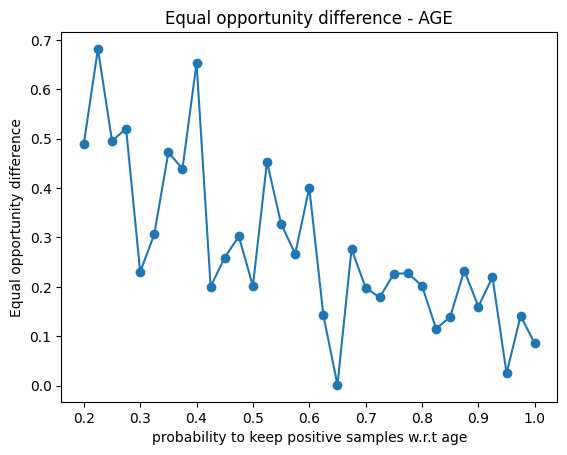

Spearman r correlation test for age bias injection:  SignificanceResult(statistic=-0.7740641711229946, pvalue=1.2628541745979532e-07)

--------- INJECT BIAS FOR GENDER----------



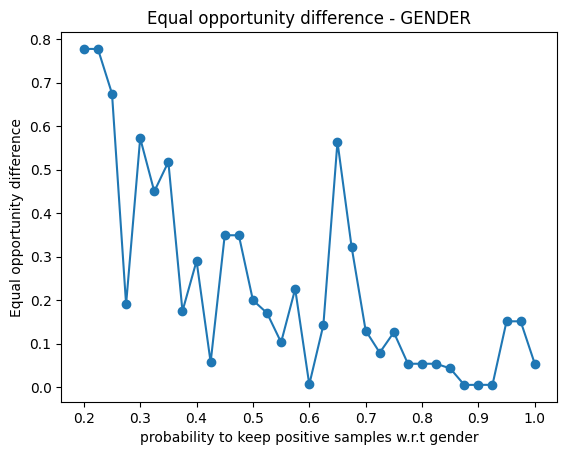

Spearman r correlation test for gender bias injection:  SignificanceResult(statistic=-0.7625419766092241, pvalue=2.5016103820881206e-07)


In [3]:

###Fairness reudction w.r.t. AGE (i.e. drop positive age samples)

print('-----  INJECT BIAS FOR AGE -----')

p2=ls_fixed[0] #Fix bias injection for gender (keep it fixed)
vals_before=[]
for p1 in ls_vary:
    vals_before.append(train_initial_fairness_age[(p1,p2)]) ## Fairness age 

plot_values(ls_vary, vals_before,"Equal opportunity difference - AGE",x_axis_name="probability to keep positive samples w.r.t age", y_axis_name="Equal opportunity difference")
print('Spearman r correlation test for age bias injection: ',spearmanr(ls_vary, vals_before))





print()
print("--------- INJECT BIAS FOR GENDER----------")
print()



p1=ls_fixed[0] #Fix bias injection for age (keep it fixed)
vals_before=[]
for p2 in ls_vary:
    vals_before.append(train_initial_fairness_gender[(p1,p2)]) ## Fairness gender

plot_values(ls_vary, vals_before,"Equal opportunity difference - GENDER",x_axis_name="probability to keep positive samples w.r.t gender", y_axis_name="Equal opportunity difference")
print('Spearman r correlation test for gender bias injection: ',spearmanr(ls_vary, vals_before))







# Compare results for fairness and accuracy before and after optimization

Plots for train

---------- OPTIMIZE W.R.T AGE----------


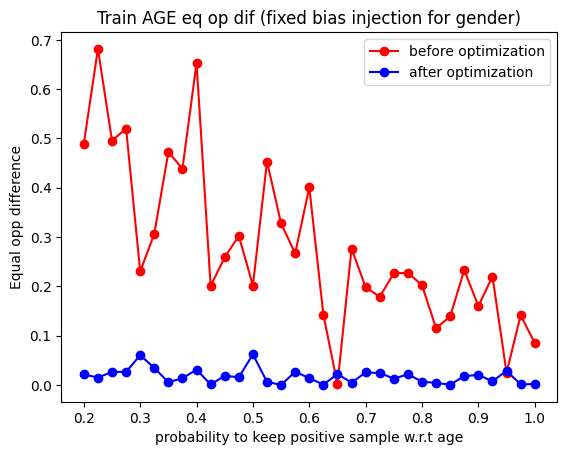

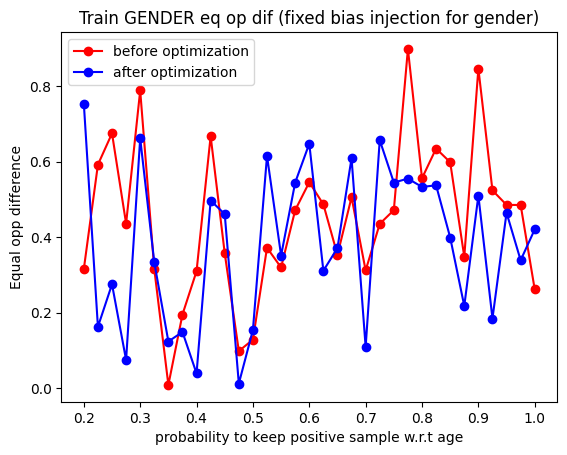

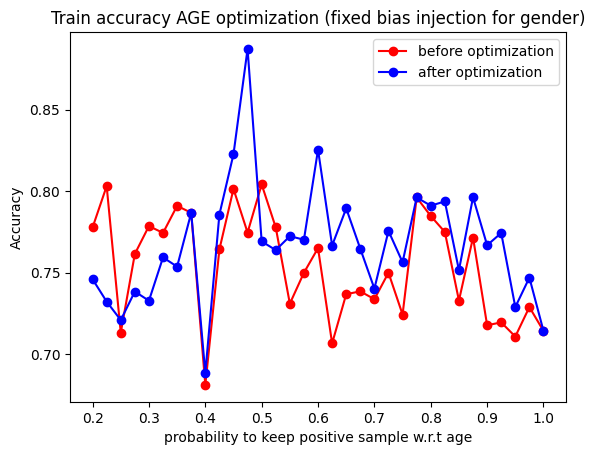

---------- OPTIMIZE W.R.T GENDER----------


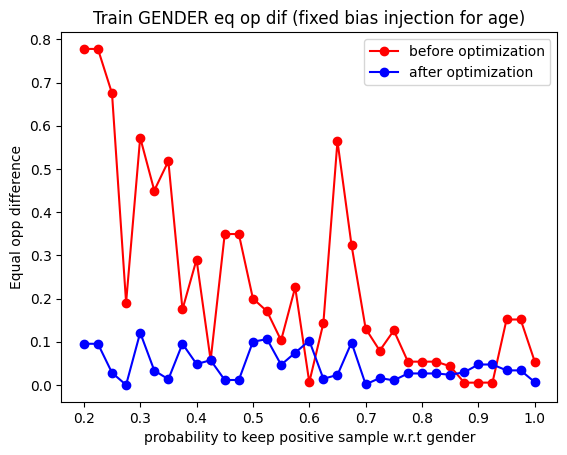

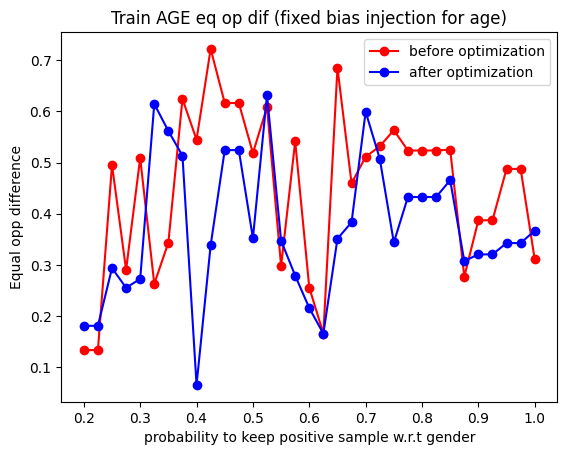

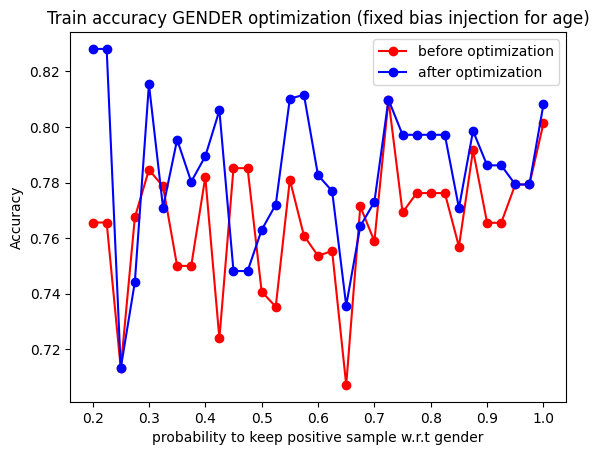

In [8]:

### OPTIMIZATION w.r.t age
#p1 for age; p2 for gender

vals_before=[]
vals_after=[]


print("---------- OPTIMIZE W.R.T AGE----------")

p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(train_initial_fairness_age[(p1,p2)])
    vals_after.append(train_fairness_age_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train AGE eq op dif (fixed bias injection for gender)", 
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(train_initial_fairness_gender[(p1,p2)])
    vals_after.append(train_fairness_gender_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train GENDER eq op dif (fixed bias injection for gender)",
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")



###ACCURACY reduction
    

vals_before=[]
vals_after=[]
p2=ls_fixed[0]    
for p1 in ls_vary:
    vals_before.append(train_acc_scores_initial[(p1,p2)])
    vals_after.append(train_acc_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Train accuracy AGE optimization (fixed bias injection for gender)"
                        ,x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Accuracy")


    


print("---------- OPTIMIZE W.R.T GENDER----------")

## Optimization w.r.t gender
vals_before=[]
vals_after=[]
p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(train_initial_fairness_gender[(p1,p2)])
    vals_after.append(train_fairness_gender_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train GENDER eq op dif (fixed bias injection for age)", 
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(train_initial_fairness_age[(p1,p2)])
    vals_after.append(train_fairness_age_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Train AGE eq op dif (fixed bias injection for age)",
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")



###ACCURACY reduction
    

vals_before=[]
vals_after=[]
p1=ls_fixed[0]    
for p2 in ls_vary:
    vals_before.append(train_acc_scores_initial[(p1,p2)])
    vals_after.append(train_acc_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Train accuracy GENDER optimization (fixed bias injection for age)"
                        ,x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Accuracy")


 



Plots for test

---------- OPTIMIZE W.R.T AGE----------


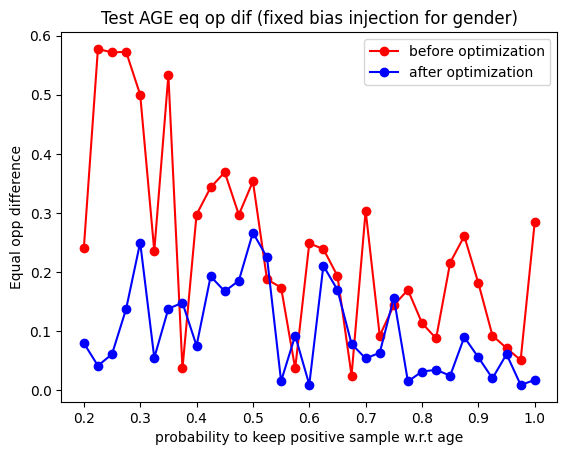

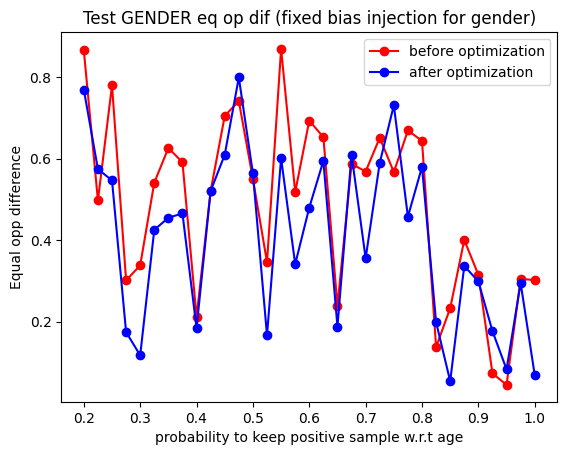

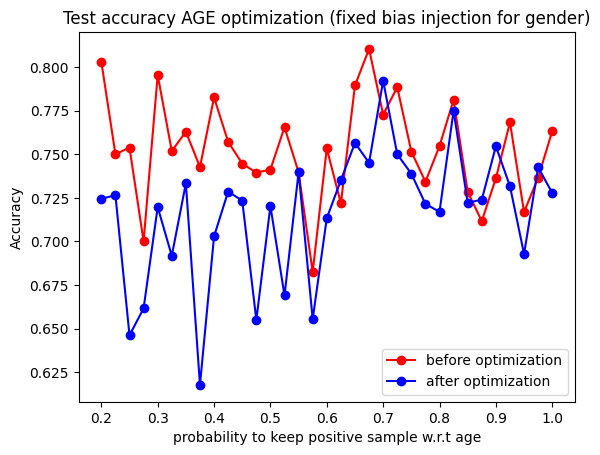



---------- OPTIMIZE W.R.T GENDEER----------


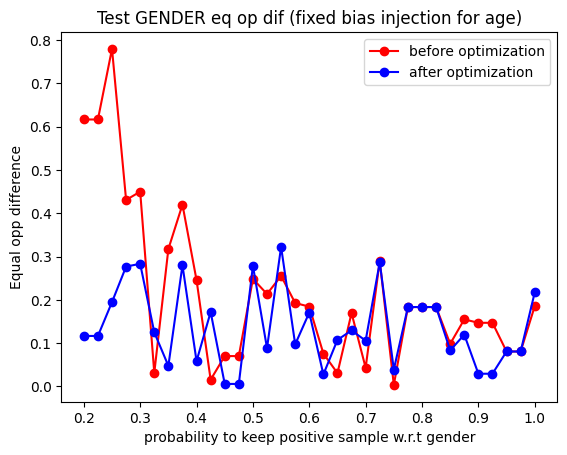

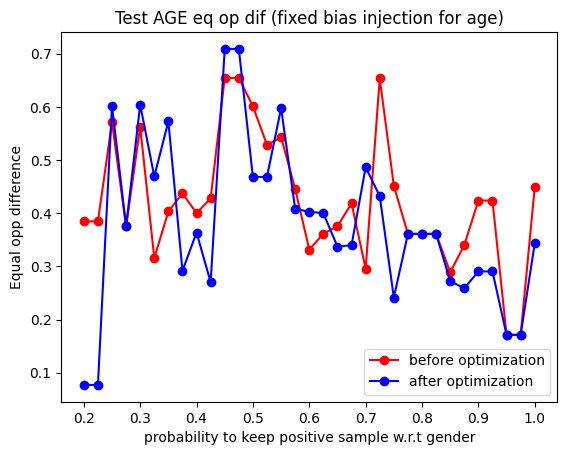

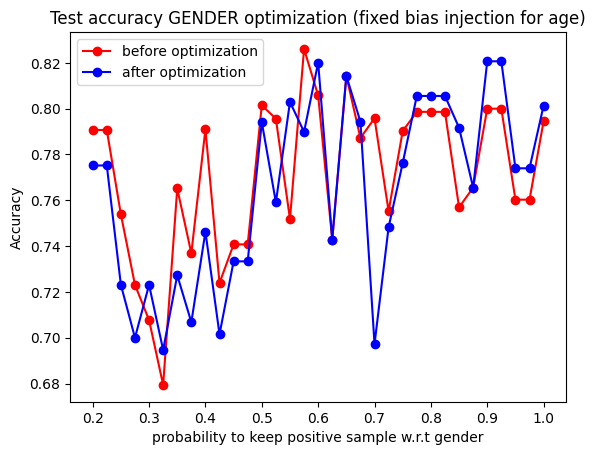

In [9]:

### OPTIMIZATION w.r.t age

vals_before=[]
vals_after=[]

print("---------- OPTIMIZE W.R.T AGE----------")

p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(test_initial_fairness_age[(p1,p2)])
    vals_after.append(test_fairness_age_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test AGE eq op dif (fixed bias injection for gender)", 
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
p2=ls_fixed[0]
for p1 in ls_vary:
    vals_before.append(test_initial_fairness_gender[(p1,p2)])
    vals_after.append(test_fairness_gender_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test GENDER eq op dif (fixed bias injection for gender)",
                        x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Equal opp difference")



###ACCURACY reduction
    

vals_before=[]
vals_after=[]
p2=ls_fixed[0]    
for p1 in ls_vary:
    vals_before.append(test_acc_scores_initial[(p1,p2)])
    vals_after.append(test_acc_scores_optim_age[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Test accuracy AGE optimization (fixed bias injection for gender)"
                        ,x_axis_name="probability to keep positive sample w.r.t age", y_axis_name="Accuracy")









## Optimize w.r.t gender
vals_before=[]
vals_after=[]
print()
print()
print("---------- OPTIMIZE W.R.T GENDEER----------")

p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(test_initial_fairness_gender[(p1,p2)])
    vals_after.append(test_fairness_gender_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test GENDER eq op dif (fixed bias injection for age)", 
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")

vals_before=[]
vals_after=[]
p1=ls_fixed[0]
for p2 in ls_vary:
    vals_before.append(test_initial_fairness_age[(p1,p2)])
    vals_after.append(test_fairness_age_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2= vals_after, plot_name=f"Test AGE eq op dif (fixed bias injection for age)",
                        x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Equal opp difference")



    

vals_before=[]
vals_after=[]
p1=ls_fixed[0]    
for p2 in ls_vary:
    vals_before.append(test_acc_scores_initial[(p1,p2)])
    vals_after.append(test_acc_scores_optim_gender[(p1,p2)] )
plot_values_with_legend(x_values=ls_vary, y_values1=vals_before, y_values2=vals_after, plot_name=f"Test accuracy GENDER optimization (fixed bias injection for age)"
                        ,x_axis_name="probability to keep positive sample w.r.t gender", y_axis_name="Accuracy")


    



# Correlation between bias injection and fairness/accuracy increase. Correlatiom between fairness increase in one feature and fairness increase in the other/increase in accuracy
( i.e. correlation between increase in fairness and increase in accuracy, and between increase in fairness for one feature and fairness for the other feature.) 
also do plots with x axis the percentage of positive sample kept w.r.t to one feature and y axis the fairness/acc increase after optimization.


Train data

----------- TRAIN DATA ----------


----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- 

-----Vary age and optimize w.r.t age-----



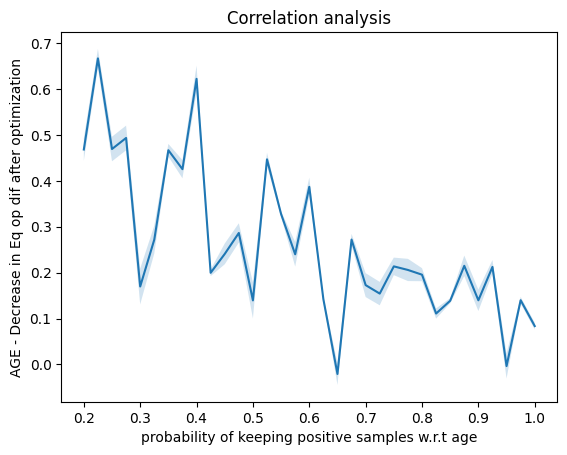

 Correlation between probability of keeping positive samples w.r.t age and age fairness increase: SignificanceResult(statistic=-0.7225935828877006, pvalue=2.0495366874726633e-06)


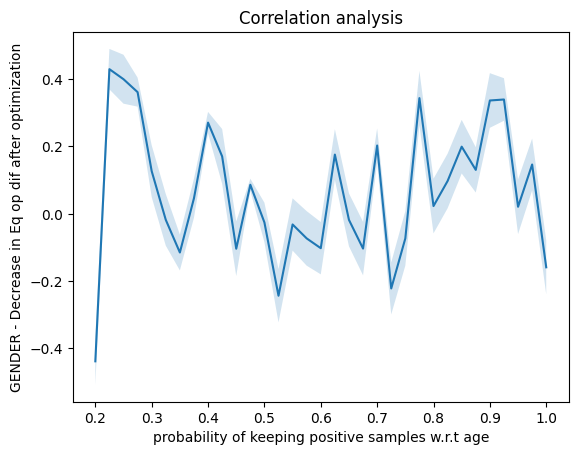

  Correlation between probability of keeping positive samples w.r.t age and gender fairness increase: SignificanceResult(statistic=0.002172641438186376, pvalue=0.9904259147492588)


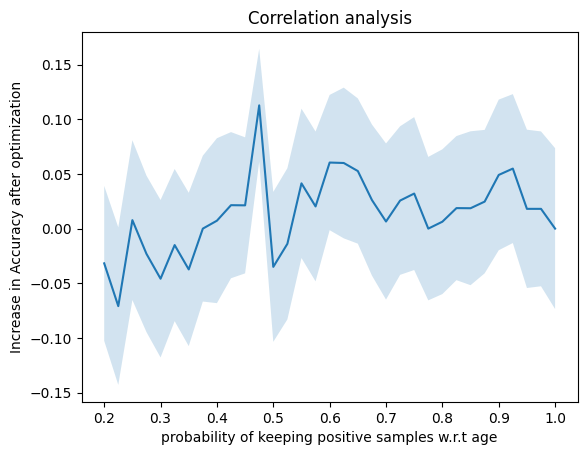

 Correlation between probability of keeping positive samples w.r.t age and accuracy increase: SignificanceResult(statistic=0.45189337726140366, pvalue=0.008289565291909362)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between age fairness improvement and gender fairness improvement : SignificanceResult(statistic=0.030082727605657514, pvalue=0.8680104511614861)
Coorelation between age fairness improvement and accuracy improvement : SignificanceResult(statistic=-0.2521106966001468, pvalue=0.1569497255971101)


----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- 

-----Vary gender and optimize w.r.t gender-----



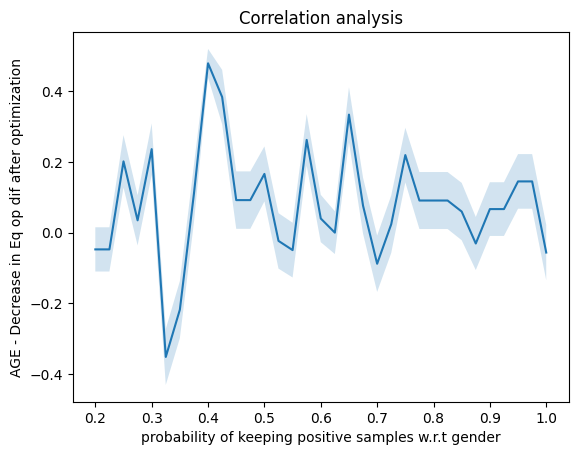

 Correlation between probability of keeping positive samples w.r.t gender and age fairness increase: SignificanceResult(statistic=-0.004347827059613997, pvalue=0.9808419314795601)


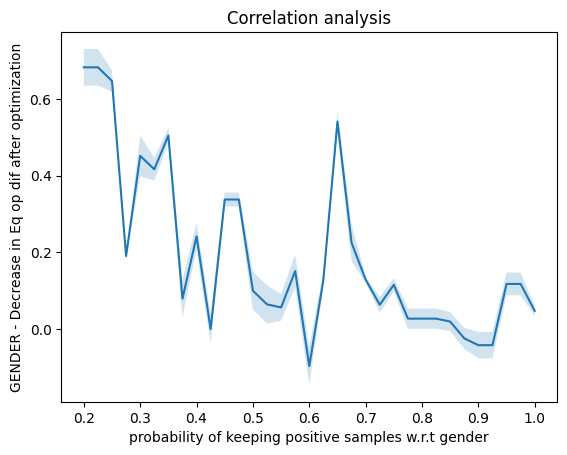

 Correlation between probability of keeping positive samples w.r.t gender and gender fairness increase: SignificanceResult(statistic=-0.6742476424755244, pvalue=1.6915082153950543e-05)


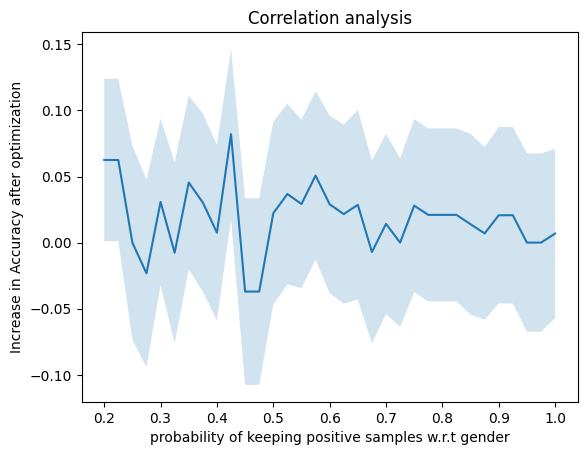

Correlation between probability of keeping positive samples w.r.t gender and accuracy increase: SignificanceResult(statistic=-0.2843279589843537, pvalue=0.10878938669999699)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between gender fairness improvement and age fairness improvement : SignificanceResult(statistic=0.052543507362784465, pvalue=0.7715089940076695)
Coorelation between gender fairness improvement and accuracy improvement : SignificanceResult(statistic=-0.027966180594184507, pvalue=0.8772242257863491)




In [6]:


print("----------- TRAIN DATA ----------")

print()
print()


print("----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- ")
print()
find_trend_optimization(before_fairness_age = train_initial_fairness_age , before_fairness_gender= train_initial_fairness_gender, before_accuracy = train_acc_scores_initial,
                        after_fairness_age = train_fairness_age_scores_optim_age, after_fairness_gender = train_fairness_gender_scores_optim_age, after_accuracy = train_acc_scores_optim_age,
                        correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=True, size1=X_val_with_A.shape[0], size2=X_val_with_A.shape[0])
    
            
         
print("----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend_optimization(before_fairness_age = train_initial_fairness_age , before_fairness_gender= train_initial_fairness_gender, before_accuracy = train_acc_scores_initial,
                        after_fairness_age = train_fairness_age_scores_optim_gender, after_fairness_gender = train_fairness_gender_scores_optim_gender, after_accuracy = train_acc_scores_optim_gender,
                        correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=False, size1=X_val_with_A.shape[0], size2=X_val_with_A.shape[0])




Test data

----------- TEST DATA ----------


----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- 

-----Vary age and optimize w.r.t age-----



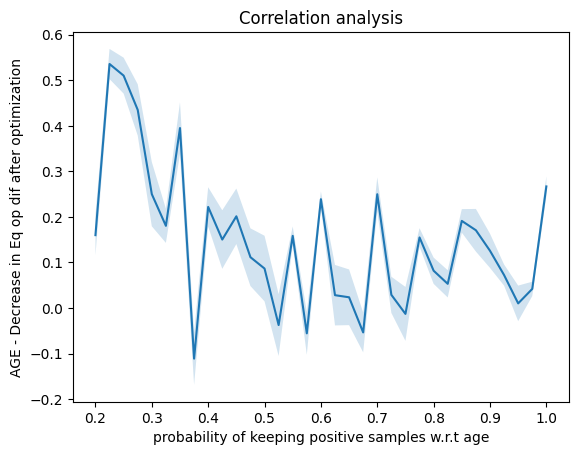

 Correlation between probability of keeping positive samples w.r.t age and age fairness increase: SignificanceResult(statistic=-0.38402406417112306, pvalue=0.027358345283807258)


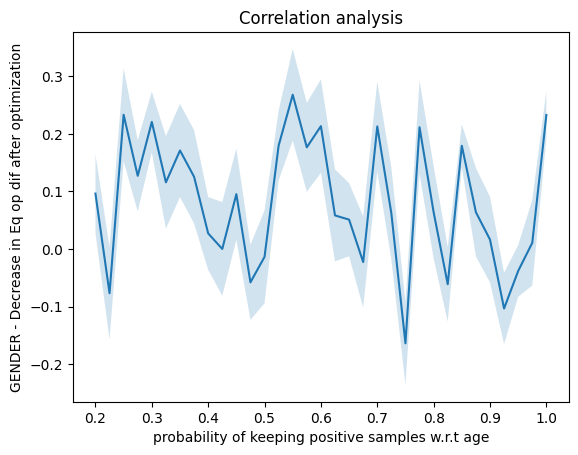

  Correlation between probability of keeping positive samples w.r.t age and gender fairness increase: SignificanceResult(statistic=-0.21557486631016043, pvalue=0.2282563541596554)


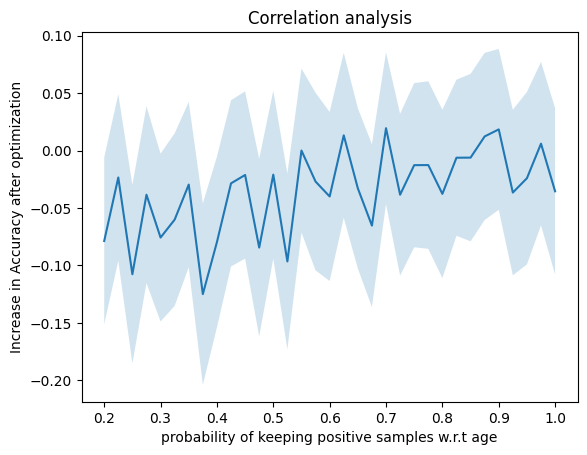

 Correlation between probability of keeping positive samples w.r.t age and accuracy increase: SignificanceResult(statistic=0.5381465716123178, pvalue=0.0012364202573277023)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between age fairness improvement and gender fairness improvement : SignificanceResult(statistic=0.4214572192513369, pvalue=0.014576226974034049)
Coorelation between age fairness improvement and accuracy improvement : SignificanceResult(statistic=-0.012033091042263007, pvalue=0.9470101760861758)


----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- 

-----Vary gender and optimize w.r.t gender-----



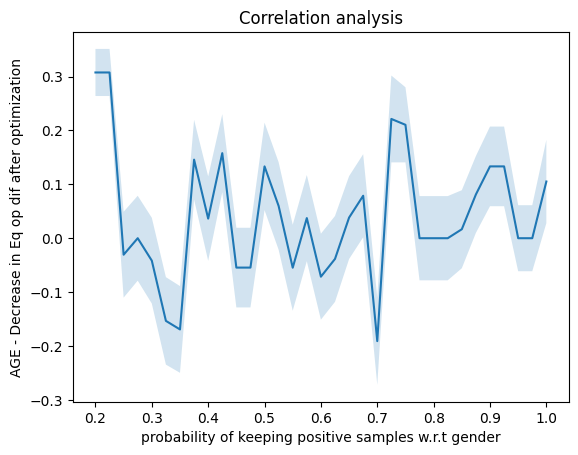

 Correlation between probability of keeping positive samples w.r.t gender and age fairness increase: SignificanceResult(statistic=0.07670425146531604, pvalue=0.6713701198109561)


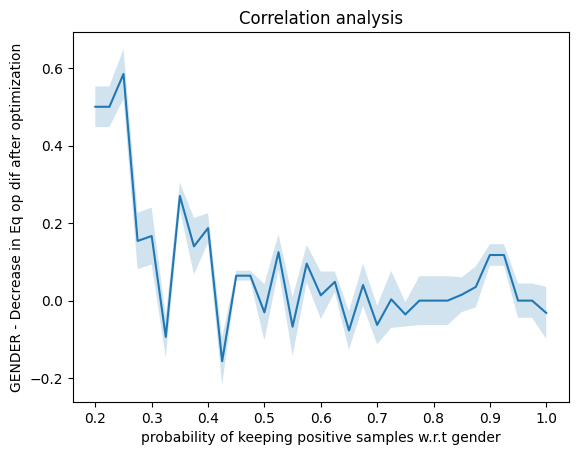

 Correlation between probability of keeping positive samples w.r.t gender and gender fairness increase: SignificanceResult(statistic=-0.48505740818014886, pvalue=0.00422240208176897)


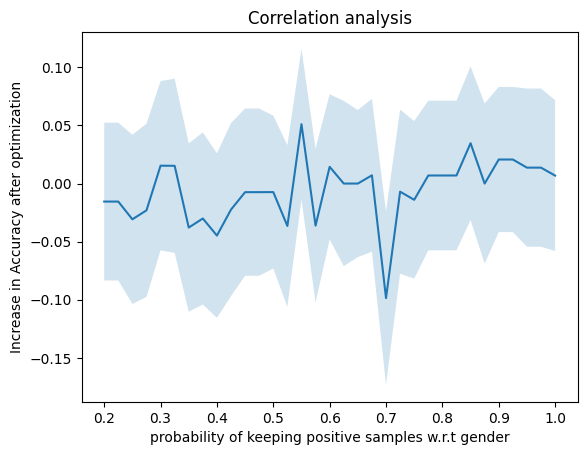

Correlation between probability of keeping positive samples w.r.t gender and accuracy increase: SignificanceResult(statistic=0.5075278568396299, pvalue=0.002571204388997698)

-- RESULTS ABOUT CORRELATION BETWEEN FAIRNESS AND ACC --
Coorelation between gender fairness improvement and age fairness improvement : SignificanceResult(statistic=0.11846631804067252, pvalue=0.5114284069585365)
Coorelation between gender fairness improvement and accuracy improvement : SignificanceResult(statistic=-0.34408796987492163, pvalue=0.04990729224919076)




In [7]:
from scipy.stats import spearmanr

print("----------- TEST DATA ----------")

print()
print()


print("----- Trends in comparing BEFORE and AFTER optimization w.r.t age when injecting bias in age (i.e vary age) ----- ")
print()
find_trend_optimization(before_fairness_age = test_initial_fairness_age , before_fairness_gender= test_initial_fairness_gender, before_accuracy = test_acc_scores_initial,
                after_fairness_age = test_fairness_age_scores_optim_age, after_fairness_gender = test_fairness_gender_scores_optim_age, after_accuracy = test_acc_scores_optim_age,
                correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=True, size1=X_test_with_A.shape[0], size2=X_test_with_A.shape[0])
    
            
         
print("----- Trends in comparing BEOFRE and AFTER optimization  w.r.t gender when injecting bias in gender (i.e. vary gender) ----- ")
print()
find_trend_optimization(before_fairness_age = test_initial_fairness_age , before_fairness_gender= test_initial_fairness_gender, before_accuracy = test_acc_scores_initial,
                after_fairness_age = test_fairness_age_scores_optim_gender, after_fairness_gender = test_fairness_gender_scores_optim_gender, after_accuracy = test_acc_scores_optim_gender,
                correlation_test = spearmanr, ls_p_vary = ls_vary, vary_age=False, size1=X_test_with_A.shape[0], size2=X_test_with_A.shape[0])


